# Moving mnist for validation of models - SEQ-SEQ

Implementation based on 
https://towardsdatascience.com/video-prediction-using-convlstm-with-pytorch-lightning-27b195fd21a2

## POC - Not Optimised

# Data loading

In [1]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import sys
import os
import errno
import numpy as np
import torch
import codecs
from datetime import datetime
sys.path.append('../')
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from model.ConvLSTM import ConvLSTMCell
from model.ConvLSTM_models import EncoderDecoderConvLSTM
import torchvision.utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from datahelpers import *
from IPython.display import clear_output
from torchvision.utils import save_image, make_grid

# Parameters

In [2]:
# Size of dim 0 of grid
n_steps_past = 10
n_steps_ahead = 1  # 4
NF=60
batch_size=2

# For saving
MODEL_NAME="Seq_seq_10_step_model"

# Data loader 

In [153]:
relative_path='../.data/mnist'

train_set = MovingMNIST(root=relative_path, train=True, download=False, max_norm=True)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)


validation_set = MovingMNIST(root=relative_path, train=False, download=False, max_norm=True)

validation_loader = torch.utils.data.DataLoader(
                 dataset=validation_set,
                 batch_size=batch_size,
                 shuffle=True)

In [3]:
model = EncoderDecoderConvLSTM(nf=NF, in_chan=1)
CUDA=False
if torch.cuda.is_available():
    print("Cuda")
    CUDA=True
    model.cuda()

### Load a pretrained model

In [4]:
model.load_state_dict(torch.load('../state_dict/model_tranied_MSELoss_Seq_seq_10_step_model_NF60_finish_encodedecode_mmnist',map_location=torch.device('cpu')))

<All keys matched successfully>

### Get model parameters

In [5]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

910861


In [97]:
# Print model parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([240, 61, 3, 3])
torch.Size([240])
torch.Size([240, 120, 3, 3])
torch.Size([240])
torch.Size([240, 120, 3, 3])
torch.Size([240])
torch.Size([240, 120, 3, 3])
torch.Size([240])
torch.Size([1, 60, 1, 3, 3])
torch.Size([1])


# Loss

In [98]:
criterion = nn.MSELoss()

# Optimizer

In [99]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Traning

### Verify model

In [100]:
# Reproduceabilitu
torch.manual_seed(3124)
np.random.seed(224)

In [101]:
for i, (inputs, target) in enumerate(train_loader):
    break

In [102]:
# Add channel and do forward pass
# B,T,C,H,W

# Asure that we get the correct number of timesteps
assert(model(inputs.unsqueeze(2), future_seq=n_steps_ahead, cuda=CUDA).shape[2]==n_steps_ahead)

### Helper functions 

For keeping track of learning and plotting predictions


In [122]:
def save_prediction(pred:torch.tensor, file_prefix:str = '', file_postfix:str = '', nrow=10):
    """
    Assumes tensor (b, t, c, h, w)
    """
    
    path = file_prefix
    if not file_prefix:
        path='moving_mnist_'
    for b in range(pred.shape[0]):
        torchvision.utils.save_image(make_grid(pred[b,:,:,:,:], padding=100, nrow=nrow), str(path)+ f'batchnr{b}'+str(file_postfix)+".png")
        
def plot_prediction(pred:torch.tensor,nrow=10):
    # Remove batch
    # b,t,c,w,h
    if len(pred.shape)>4:
        pred = [y for x in pred for y in x]
    plt.imshow(np.rot90(np.transpose(make_grid(pred,nrow=nrow).numpy())),origin='lower')
    plt.title("Prediction")
    
def plot_output_v_target(target, outputs, nrow=10):
    pred_eval = _join_out_ta(target, outputs)
    plot_prediction(pred_eval, nrow=nrow)
    
def save_output_v_target(target:torch.tensor, outputs:torch.tensor, nrow=10, file_prefix:str = '', file_postfix:str = ''):
    pred_eval = _join_out_ta(target, outputs)
    save_prediction(pred_eval, nrow=nrow, file_prefix=file_prefix, file_postfix=file_postfix)

def _join_out_ta(target, outputs):
    # Example
    # torch.cat((inputs.unsqueeze(2),model(inputs.unsqueeze(2), future_seq=10).permute(0,2,1,3,4)),dim=1)
    
    # assert same size except timesteps
    assert (target[:,0,:,:,:].shape==outputs[:,0,:,:,:].shape) and (len(target.shape)==5)
    return torch.cat((target, outputs), dim=1)

### Train model our dataset

In [ ]:
SAVE_CHECKPOINTS=True

num_epochs = 30
itr = 0
# Save loss for plot
training_loss=[]
validation_loss=[]

t_L=train_loader

print("Start Iter")

# Status parameters
data_train_iter=75

global_steps =0
log_every=150

# Monitoring
t1=datetime.now()
t2=datetime.now()
for epoch in range(num_epochs):
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.eval()
    # For grid in validation set
    print("Starting validation")
    for i, (inputs, targets) in enumerate(validation_loader):
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets
        if CUDA:
            y = y.cuda()

        # Forward pass to get output/logits
        y_hat = model.forward(x, future_seq=n_steps_ahead, cuda=CUDA).squeeze()
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y_hat, y)

        # Getting gradients w.r.t. parameters
        epoch_validation_loss += loss.cpu().detach().numpy()

    model.train()
    # For grid in traning set
    print("Starting Train")
    for i, (inputs,targets) in enumerate(train_loader):
        # Status updates
        if i%data_train_iter==0: 
            print(f"Done with {int(i*100/len(t_L))}% of train in epoch {epoch} \nSeconds since start: {(datetime.now()-t1).seconds} \nSeconds since last status: {(datetime.now()-t2).seconds}")
            t2=datetime.now()
        # Add channel
        x = inputs.unsqueeze(2)
        y = targets
        if CUDA:
            y = y.cuda()

        # Forward pass to get output/logits
        y_hat = model.forward(x, future_seq=n_steps_ahead,cuda=CUDA).squeeze()
        
        # Calculate Loss: softmax --> cross entropy loss
        # outputs shifts channel one place left
        loss = criterion(y_hat, y)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Update loss
        epoch_training_loss += loss.cpu().detach().numpy()
        
        # Status updates
        # Print loss every x steps after 1
        if (global_steps % log_every == 0) and len(validation_loss)>0:
            #Report status
            print(f'Epoch: {epoch}, Global steps: {global_steps}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            # Plot prediction
            plt.figure(figsize=(15,20))
            plt.subplot(2, 1, 1)
            plot_output_v_target(inputs.cpu().unsqueeze(2), y_hat.cpu().unsqueeze(1).permute(0,2,1,3,4).detach())
            plt.subplot(2, 1, 2)
            _epoch = np.arange(len(training_loss))
            plt.plot(_epoch, training_loss, 'r', label='Training loss',)
            plt.plot(_epoch, validation_loss, 'b', label='Validation loss')
            plt.title("Traning and validation loos")
            plt.legend()
            plt.xlabel('Epoch'), plt.ylabel('VAL')
            plt.show()
            clear_output(wait=True)

            # Save pred
            try:
                save_prediction(y_hat.cpu().unsqueeze(1).permute(0,2,1,3,4).detach(), f'./predictions/{type(model).__name__}_pred',epoch)
            except Exception as e:
                pass
                
        # Step taken
        global_steps+=1
        
    # Save
    if SAVE_CHECKPOINTS:
        model_name=f'{type(model).__name__}_{type(criterion).__name__}_checkpoint_{datetime.now()}'
        # Send dict to memory
        torch.save(model.state_dict(), model_name)
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(train_loader))
    validation_loss.append(epoch_validation_loss/len(validation_loader))

Done with 15% of train in epoch 8 
Seconds since start: 2025 
Seconds since last status: 12


### Loss evaluation

In [ ]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.title("Traning and validation loos")
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

### Validation loss calculator and image extractor for report

Used for the report performance evalutation

Single prediction

In [159]:
model.eval()
epoch_validation_loss=0
for i, (inputs, targets) in enumerate(validation_loader):
    # Add channel
    x = inputs.unsqueeze(2)
    y = targets
    if CUDA:
        y = y.cuda()

    # Forward pass to get output/logits
    y_hat = model.forward(x, future_seq=n_steps_ahead, cuda=CUDA).squeeze()

    # Calculate Loss: softmax --> cross entropy loss
    # outputs shifts channel one place left
    loss = criterion(y_hat, y[:,0,:,:])

    # Getting gradients w.r.t. parameters
    epoch_validation_loss += loss.cpu().detach().numpy()

In [160]:
epoch_validation_loss

8.011850663926452

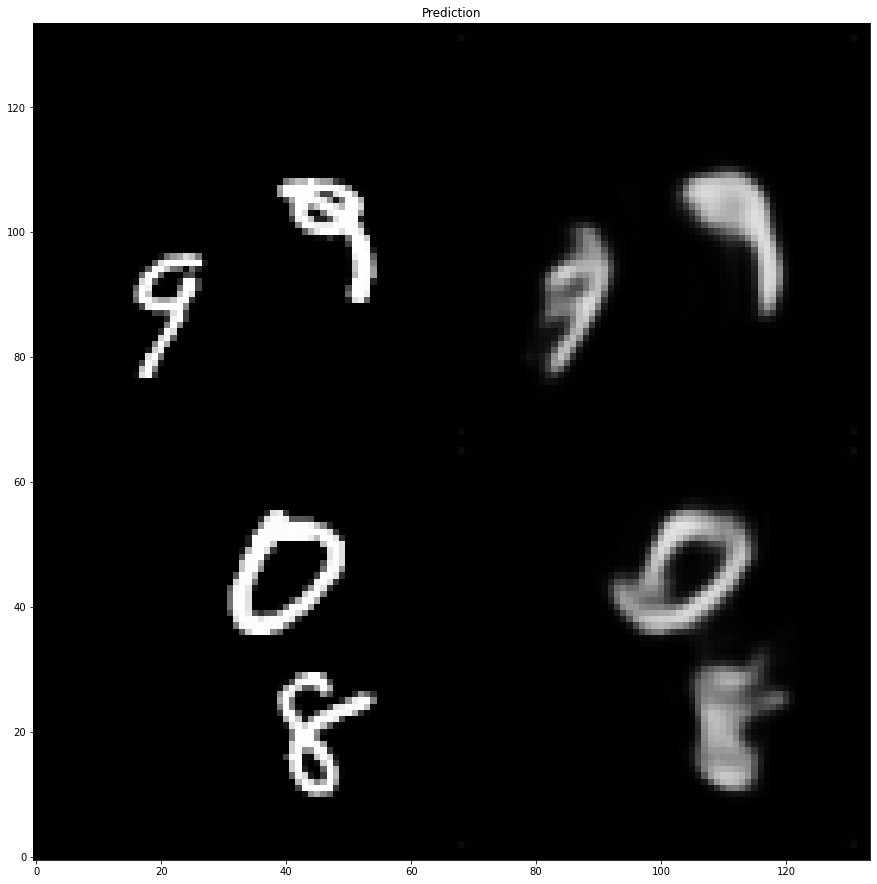

In [125]:
# Get two examples
plt.figure(figsize=(15,20))
plot_output_v_target(y.unsqueeze(1)[1:3,:,0,:,:].unsqueeze(1).detach(), y_hat.unsqueeze(1).unsqueeze(1).detach()[1:3,:,:,:,:],nrow=2)
plt.savefig('report_seq_seq')


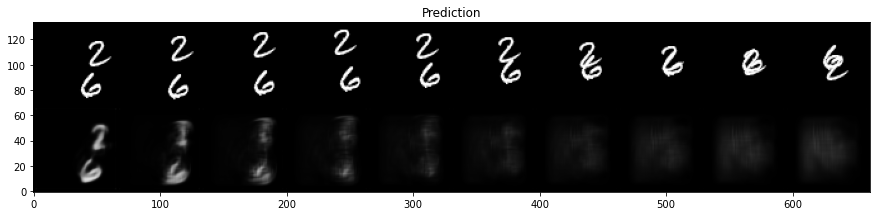

In [151]:
# A single prediction
plt.figure(figsize=(15,20))
plot_output_v_target(y.cpu().unsqueeze(2)[1].unsqueeze(0), y_hat.cpu().unsqueeze(2).detach()[1].unsqueeze(0), nrow=10)
plt.savefig('Futurepred')

## Saving the model

In [ ]:
model_name=f'model_tranied_'+str(type(criterion).__name__)+'_'+MODEL_NAME+'_finish_{datetime.now()}'
torch.save(model.state_dict(), model_name)